In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import StratifiedKFold

In [2]:
data = pd.read_csv("data_waveforms_incomplete.csv")
data = data.rename(columns={"icu_length": "inpatient"})
data = data.drop(columns=['death_inhosp','Mahalanobis','age_group','caseid','subjectid'])
data.head()

,Age,Ht,Wt,Sex,OP_time,Open,Robotic,Videoscopic,icu_days,inpatient,rmssds,jumps,perc_outs
0,18.0,175.1,59.2,0,292.55,1,0,0,3,1,0.012279,3,7.787555
1,0.7,64.1,8.9,1,475.00,1,0,0,38,1,0.011702,2,4.093900
2,0.6,42.0,5.6,1,435.00,1,0,0,15,1,0.016955,0,2.513406
3,0.8,64.1,8.9,1,115.00,1,0,0,38,1,0.010308,0,0.417537
4,18.0,185.0,62.6,0,210.00,1,0,0,1,0,0.037247,7,6.031319


# Multiple Linear Regression

For this section, we will only consider people who did have ICU stays and will predict the number of days their stay lasted.

There are 908 training instances and 228 testing instances


(array([219.,   6.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  1. ,  18.8,  36.6,  54.4,  72.2,  90. , 107.8, 125.6, 143.4,
        161.2, 179. ]),
 <BarContainer object of 10 artists>)

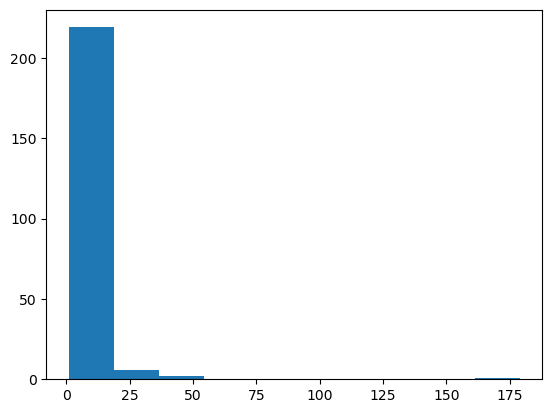

In [3]:
# select the relevant variables
X_ml = data[['Age', 'Ht', 'Wt', 'Sex', 'OP_time', 'Open', 'Robotic', 'Videoscopic', 'rmssds', 'jumps', 'perc_outs']]
y_ml = data['icu_days']

# test/train split
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X_ml, y_ml, test_size=0.2, random_state=10)

print(f'There are {len(y_train_ml)} training instances and {len(y_test_ml)} testing instances')

# train the model and make predictions
model_ml = LinearRegression()
model_ml.fit(X_train_ml, y_train_ml)
y_prediction_ml = model_ml.predict(X_test_ml)

plt.figure()
plt.hist(y_test_ml)

The feature variables explain -0.38402403904631566% of the variance in number of ICU days
The root mean squared error is 13.12511311137983


/Users/dylanmack/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


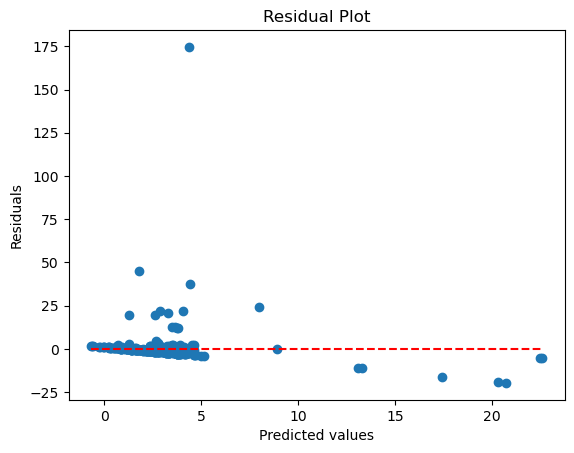

In [4]:
# Coefficient of Determination (R²):
# R² explains the proportion of variance in the target variable that is explained by the predictors.
r2_ml = r2_score(y_test_ml, y_prediction_ml)
print(f'The feature variables explain {100*r2_ml}% of the variance in number of ICU days')

rmse_ml = mean_squared_error(y_test_ml, y_prediction_ml, squared = False)
print(f'The root mean squared error is {rmse_ml}')

# plotting residuals
residuals_ml = y_test_ml - y_prediction_ml
plt.scatter(y_prediction_ml, residuals_ml)
plt.hlines(0, min(y_prediction_ml), max(y_prediction_ml), colors="r", linestyles="dashed")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

# Logistic Regression (ICU)

Predict whether or not someone will have long or short ICU stay.

In [5]:
X_lr_icu = data[['Age', 'Ht', 'Wt', 'Sex', 'OP_time', 'Open', 'Robotic', 'Videoscopic', 'rmssds', 'jumps', 'perc_outs']]
y_lr_icu = data['inpatient']

X_train_lr_icu, X_test_lr_icu, y_train_lr_icu, y_test_lr_icu = train_test_split(X_lr_icu, y_lr_icu, test_size=0.2, random_state=42)
print(f'There are {len(y_train_lr_icu)} training instances and {len(y_test_lr_icu)} testing instances')

# train the model and make predictions
model_lr_icu = LogisticRegression(class_weight="balanced", solver='liblinear', random_state=42)
model_lr_icu.fit(X_train_lr_icu, y_train_lr_icu)
y_prediction_lr_icu = model_lr_icu.predict(X_test_lr_icu)

There are 908 training instances and 228 testing instances


In [6]:
accuracy_icu = accuracy_score(y_test_lr_icu, y_prediction_lr_icu)
print("Accuracy:", accuracy_icu)

# Classification Report
print("Classification Report:\n", classification_report(y_test_lr_icu, y_prediction_lr_icu))

Accuracy: 0.6885964912280702
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.61      0.73       157
           1       0.50      0.86      0.63        71

    accuracy                           0.69       228
   macro avg       0.70      0.74      0.68       228
weighted avg       0.78      0.69      0.70       228



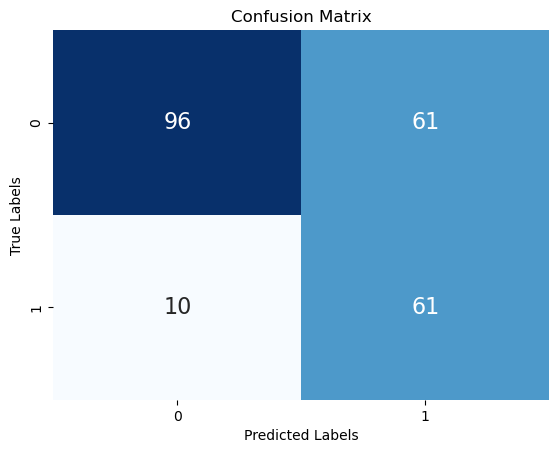

In [7]:
# confusion matrix visualization

cm_icu = confusion_matrix(y_test_lr_icu, y_prediction_lr_icu)

plt.figure()
sns.heatmap(cm_icu, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Random Forest (ICU)

There are 908 training instances and 228 testing instances
Accuracy: 0.7631578947368421
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.87      0.84       157
           1       0.65      0.52      0.58        71

    accuracy                           0.76       228
   macro avg       0.73      0.70      0.71       228
weighted avg       0.75      0.76      0.76       228



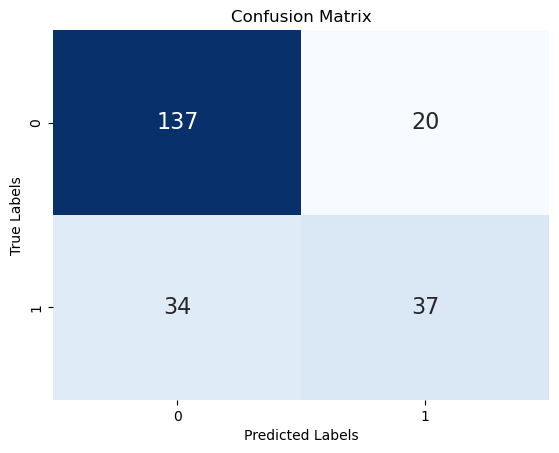

In [8]:
X_rf_icu = data[['Age', 'Ht', 'Wt', 'Sex', 'OP_time', 'Open', 'Robotic', 'Videoscopic', 'rmssds', 'jumps', 'perc_outs']]
y_rf_icu = data['inpatient']

X_train_rf_icu, X_test_rf_icu, y_train_rf_icu, y_test_rf_icu = train_test_split(X_rf_icu, y_rf_icu, test_size=0.2, random_state=42)
print(f'There are {len(y_train_rf_icu)} training instances and {len(y_test_rf_icu)} testing instances')

clf_icu = RandomForestClassifier(n_estimators=100, random_state=42)
clf_icu.fit(X_train_rf_icu, y_train_rf_icu)

y_pred_rf_icu = clf_icu.predict(X_test_rf_icu)



accuracy_rf_icu = accuracy_score(y_test_rf_icu, y_pred_rf_icu)
print("Accuracy:", accuracy_rf_icu)

# Classification Report
print("Classification Report:\n", classification_report(y_test_rf_icu, y_pred_rf_icu))

cm_rf_icu = confusion_matrix(y_test_rf_icu, y_pred_rf_icu)

plt.figure()
sns.heatmap(cm_rf_icu, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# XGBoost (ICU)

There are 908 training instances and 228 testing instances
Accuracy: 0.7368421052631579
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.85      0.82       157
           1       0.59      0.49      0.54        71

    accuracy                           0.74       228
   macro avg       0.69      0.67      0.68       228
weighted avg       0.73      0.74      0.73       228



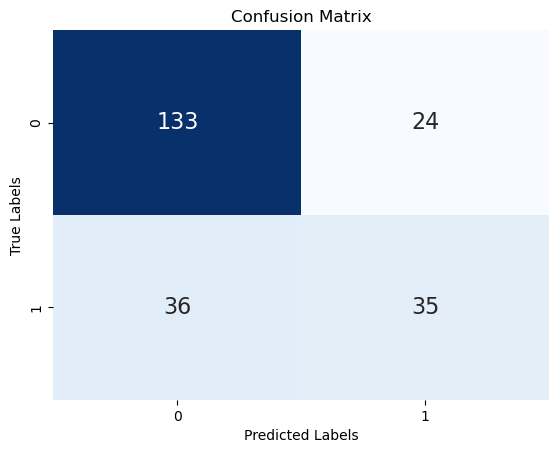

In [9]:
X_xgb_icu = data[['Age', 'Ht', 'Wt', 'Sex', 'OP_time', 'Open', 'Robotic', 'Videoscopic', 'rmssds', 'jumps', 'perc_outs']]
y_xgb_icu = data['inpatient']

X_train_xgb_icu, X_test_xgb_icu, y_train_xgb_icu, y_test_xgb_icu = train_test_split(X_xgb_icu, y_xgb_icu, test_size=0.2, random_state=42)
print(f'There are {len(y_train_xgb_icu)} training instances and {len(y_test_xgb_icu)} testing instances')

xgb_icu = xgb.XGBClassifier()
xgb_icu.fit(X_train_xgb_icu, y_train_xgb_icu)

y_pred_xgb_icu = xgb_icu.predict(X_test_xgb_icu)



accuracy_xgb_icu = accuracy_score(y_test_xgb_icu, y_pred_xgb_icu)
print("Accuracy:", accuracy_xgb_icu)

# Classification Report
print("Classification Report:\n", classification_report(y_test_xgb_icu, y_pred_xgb_icu))

cm_xgb_icu = confusion_matrix(y_test_xgb_icu, y_pred_xgb_icu)

plt.figure()
sns.heatmap(cm_xgb_icu, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# XGBoost Regression (Length of ICU Stay)

There are 908 training instances and 228 testing instances


(array([219.,   6.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  1. ,  18.8,  36.6,  54.4,  72.2,  90. , 107.8, 125.6, 143.4,
        161.2, 179. ]),
 <BarContainer object of 10 artists>)

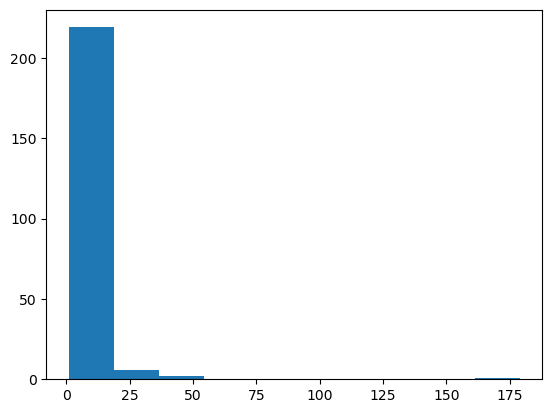

In [10]:
# select the relevant variables
X_xgb_licu = data[['Age', 'Ht', 'Wt', 'Sex', 'OP_time', 'Open', 'Robotic', 'Videoscopic', 'rmssds', 'jumps', 'perc_outs']]
y_xgb_licu = data['icu_days']

# test/train split
X_train_xgb_licu, X_test_xgb_licu, y_train_xgb_licu, y_test_xgb_licu = train_test_split(X_xgb_licu, y_xgb_licu, test_size=0.2, random_state=10)

print(f'There are {len(y_train_xgb_licu)} training instances and {len(y_test_xgb_licu)} testing instances')

# train the model and make predictions
xgb_licu = xgb.XGBRegressor()
xgb_licu.fit(X_train_xgb_licu, y_train_xgb_licu)

y_pred_xgb_licu = xgb_licu.predict(X_test_xgb_licu)

plt.figure()
plt.hist(y_test_xgb_licu)

The feature variables explain 2.1016065808068585% of the variance in number of ICU days
The root mean squared error is 12.961597668262494


/Users/dylanmack/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


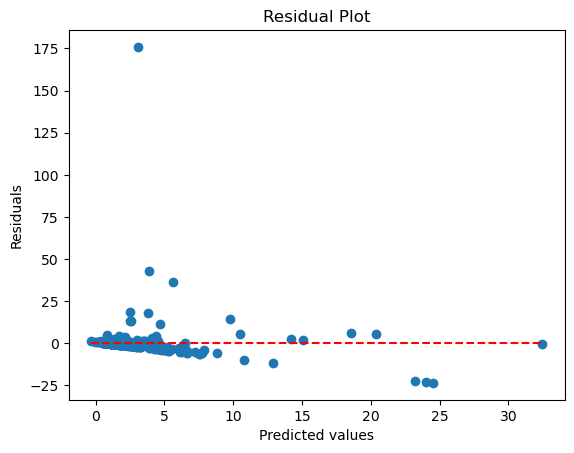

In [11]:
# Coefficient of Determination (R²):
# R² explains the proportion of variance in the target variable that is explained by the predictors.
r2_xgb_licu = r2_score(y_test_xgb_licu, y_pred_xgb_licu)
print(f'The feature variables explain {100*r2_xgb_licu}% of the variance in number of ICU days')

rmse_xgb_licu = mean_squared_error(y_test_xgb_licu, y_pred_xgb_licu, squared = False)
print(f'The root mean squared error is {rmse_xgb_licu}')

# plotting residuals
residuals_xgb_licu = y_test_xgb_licu - y_pred_xgb_licu
plt.scatter(y_pred_xgb_licu, residuals_xgb_licu)
plt.hlines(0, min(y_pred_xgb_licu), max(y_pred_xgb_licu), colors="r", linestyles="dashed")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

# Cross-Validation

From PyCaret, we found that the best model was GradientBoostingClassifier. We will use cross-validation to determine the best hyperparameters.

### Random Forest

In [12]:
rf_param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300, 500]
}

In [13]:
X = data.drop(columns=['icu_days','inpatient'])
y = data['inpatient']

clf = RandomForestClassifier()

inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=3) # for hyperparameters
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=3) # for evaluation

optimal_params = []  
roc_auc_scores = [] 

for train_idx, test_idx in outer_cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    grid_search = GridSearchCV(estimator=clf, param_grid=rf_param_grid, cv=inner_cv, scoring='roc_auc')
    grid_search.fit(X_train, y_train)

    optimal_params.append(grid_search.best_params_)
    roc_auc_scores.append(grid_search.score(X_test, y_test))

print("Nested CV ROC AUC:", np.mean(roc_auc_scores))
print("Optimal Parameters from each fold:")
print(optimal_params)

Nested CV ROC AUC: 0.7818582900308925
Optimal Parameters from each fold:
[{'max_depth': 5, 'n_estimators': 300}, {'max_depth': 3, 'n_estimators': 200}, {'max_depth': 3, 'n_estimators': 300}, {'max_depth': 7, 'n_estimators': 500}, {'max_depth': 7, 'n_estimators': 500}]


### XGBoost

In [14]:
xgb_param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'scale_pos_weight': [1, 10, 25]
}

In [15]:
X = data.drop(columns=['icu_days','inpatient'])
y = data['inpatient']

clf = xgb.XGBClassifier()

inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=3) # for hyperparameters
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=3) # for evaluation

optimal_params = []  
roc_auc_scores = [] 

for train_idx, test_idx in outer_cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    grid_search = GridSearchCV(estimator=clf, param_grid=xgb_param_grid, cv=inner_cv, scoring='roc_auc')
    grid_search.fit(X_train, y_train)

    optimal_params.append(grid_search.best_params_)
    roc_auc_scores.append(grid_search.score(X_test, y_test))

print("Nested CV ROC AUC:", np.mean(roc_auc_scores))
print("Optimal Parameters from each fold:")
print(optimal_params)

Nested CV ROC AUC: 0.7557048809269137
Optimal Parameters from each fold:
[{'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 1}, {'max_depth': 7, 'n_estimators': 200, 'scale_pos_weight': 1}, {'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 1}, {'max_depth': 5, 'n_estimators': 100, 'scale_pos_weight': 1}, {'max_depth': 7, 'n_estimators': 300, 'scale_pos_weight': 10}]


### Gradient Boosting Classifier

In [16]:
gbc_param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

In [17]:

X = data.drop(columns=['icu_days','inpatient'])
y = data['inpatient']

clf = GradientBoostingClassifier()

inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=3) # for hyperparameters
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=3) # for evaluation

optimal_params = []  
roc_auc_scores = [] 

for train_idx, test_idx in outer_cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    grid_search = GridSearchCV(estimator=clf, param_grid=gbc_param_grid, cv=inner_cv, scoring='roc_auc')
    grid_search.fit(X_train, y_train)

    optimal_params.append(grid_search.best_params_)
    roc_auc_scores.append(grid_search.score(X_test, y_test))

print("Nested CV ROC AUC:", np.mean(roc_auc_scores))
print("Optimal Parameters from each fold:")
print(optimal_params)

Nested CV ROC AUC: 0.7733975796638396
Optimal Parameters from each fold:
[{'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 100}, {'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 100}, {'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 100}, {'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 100}, {'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 100}]
